# Ражнов Богдан/МСКМ191


In [1]:
import numpy as np 
#with np.errstate(invalid='ignore'):
from numpy.random import choice
from matplotlib import pyplot as plt
import random 
import operator
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Блок инициализации

In [2]:
A = np.array([[0.95,0.05],[0.1,0.9]])                                          #матрица переходов
E = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[1/10,1/10,1/10,1/10,1/10,1/2]])
L = 900                    #длина вектора реальных состояний
#count = 0                                          #счетчик
s = np.array([2/3,1/3]) #распределение
#m = np.zeros((L,),dtype=int)
#k = np.zeros((L,),dtype=int)

# Блок функций

In [3]:
def posled (E,A,L):
    look = []          #наблюдение
    State = []         #состояние кости
    i = 0
    if (0 <= random.random() < 2/3):  # начальное состояние кости
        D = 0 # честная кость
    else:
        D = 1 # подставная кость
    while i < L:  # какая ксоть у нас выпадает в i бросок
        x = random.random()
        if (D == 0 and x < 0.05):
            D = 1
        elif (D == 1 and x < 0.1):
            D = 0
        if (D == 1): #Если подставная кость
            State.append(1) # записываем 1 тк подставная
            if random.random() <= 0.5: #если вероятность больше 0.5, то выпадет 6 
                look.append(6)
            else:
                look.append(random.randint(1, 5)) # иначе с равной вероятностью от 1 до 5
        else:
            State.append(0)
            look.append(random.randint(1, 6)) #если кость не фековая, то равновероятно выпадет от 1 до 6
        i += 1
   # print('Состояние кости:','\n',State,'\n','Что выпало:','\n', look)  
    return (State,look)

In [4]:
def check(a,b):       #Функция проверки совпадений
    #global count
    count = 0
    i = 0
    while i < len(a):
        if a[i] == b[i]:
            count += 1
        i+=1
    return(count)
     

In [5]:
# Алгоритм Витерби
#Зададим вероятности того, что стостояние i является 
def viterbi(look, E, A):
    V = np.zeros((2,L))
    P = np.zeros((2,L), dtype = int) #вероятностное состояние
    vit = np.zeros((L,), dtype = int)#массив для  для наиболее вероятных состояний
    V[:,0] = s * E[:,look[0] - 1] #нулевой столбец, где S - стационарное распределение
    for i in range(1, L):
        for j in range(2):
            V[j,i] = np.max(V[:,i - 1] * A[:,j] * E[:,look[i] - 1])
            P[j,i] = np.argmax(V[:,i - 1] * A[:,j] * E[:,look[i] - 1])
        V[:,i] /= np.max(V[:,i])
    vit[-1] = np.argmax(V[:,-1])

    for i in range(L-2, -1, -1):
        vit[i] = P[vit[i + 1],i + 1]
    return(vit)

In [6]:
def aposter(look, E, A):
    #forward
    V1 = np.zeros((2,L))             #нормированная результирущая forward матрица
    V1[:,0] = s * E[:,look[0] - 1]
    Ncoef1 = np.zeros((L,))          
    Ncoef1[0] = max (V1[:, 0])        #вектор нормировочных коэффициентов
    V1[:, 0] /= Ncoef1[0]
    for i in range(1,len(look)):
        for j in range(2):
            V1[j,i]=np.sum(V1[:,i-1]*A[:,j])*E[j,look[i]-1]
        Ncoef1[i]=np.max(V1[:,i])
        V1[:,i]/=Ncoef1[i]
    NormProbLook1=np.sum(V1[:,-1])    #нормированная вероятность наблюдения
    #backward
    V2 = np.zeros((2,L))             #нормированная backward результирущая матрица
    V2[:,-1] = np.array([1,1])
    Ncoef2 = np.zeros((L,))          
    Ncoef2[-1] = 1                     #вектор нормировочных коэффициентов
    for i in range (len(look)-2,-1,-1):
        for j in range (2):
            V2[j,i] = np.sum(V2[:,i+1]*A[j]*E[:,look[i+1]-1])
        Ncoef2[i] = max(V2[:,i])
        V2[:,i] /= Ncoef2[i]
    NormProbLook2 = np.sum(V2[:,0]*s*E[:,look[0]-1])
    #aposter
        #L = len(F)
    Result = np.zeros(L)
    for i in range(L):
        Result[i] = np.log(V1[0][i]) + sum(np.log(Ncoef1[:i+1])) + np.log(V2[0][i])\
            + sum(np.log(Ncoef2[i:])) - np.log(NormProbLook1) - sum(np.log(Ncoef1))
        result0 = np.exp(Result)
        result = 1 - result0 / (round(max(result0)))
    
    return(result)

# Блок меню

In [7]:
State, look = posled (E,A,L)
vit = viterbi(look, E, A)
viterby_result = check(State,vit)
aposter = aposter(look, E, A)

# Блок ответов

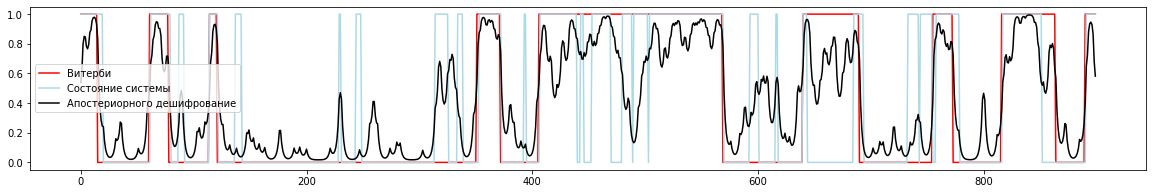

728 Совпадений с витерби из 900 бросков


In [8]:
fig, ax = plt.subplots()
a1, a2, a3 = np.arange(L),np.arange(L),np.arange(L)
b1 = vit
b2 = State
b3= ( aposter)
ax.plot(a1, b1, color = "Red", label = "Витерби")
ax.plot(a2, b2, color = "lightBlue", label = "Состояние системы")
ax.plot(a3, b3, color = "Black", label = "Апостериорного дешифрование")
ax.legend()
fig.set_size_inches(20, 3)
plt.show()
print(check(State,vit),'Совпадений с витерби из',L,'бросков')